In [1]:
# libraries
import os
import sys
import json
import numpy as np
import pandas as pd
sys.path.append(os.path.abspath('../../'))
sys.path.append(os.path.abspath('../../extra_files'))
import helper as hp
from imageio import imwrite, imread
from skimage.transform import resize

In [2]:
# File paths
data_path = '/home/aldo/Documents/data-cic/'
preprocess_path = data_path + 'preprocess_data'

## Training SSD300 trained with mobilenet backbone trained

In [3]:
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from light_models.keras_ssd300_shufflenetv2_ssdlayers_light_relu6_se_no_shuffle import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

from extra_files.f1_callback import F1_callback as f1_call

Using TensorFlow backend.
/home/aldo/Documents/ssd/data_generator/object_detection_2d_data_generator.py:43: UserWarning: 'BeautifulSoup' module is missing. The XML-parser will be unavailable.
  warnings.warn("'BeautifulSoup' module is missing. The XML-parser will be unavailable.")


### Parameters (original SSD300 architecture)

In [4]:
## Parameteres needed for ssd_300() and SSDInputEncoder()

img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [1., 1., 1.] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
divide_by_stddev = [127.5, 127.5, 127.5]
swap_channels = False # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 1 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05]
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [16, 30, 60, 100, 150, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True

## Create new model with SSD weights

In [5]:
# 1: Build the Keras model.

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                scale_factor=1.5,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)

# 3: Instantiate an optimizer and the SSD loss function and compile the model.
#    If you want to follow the original Caffe implementation, use the preset SGD
#    optimizer, otherwise I'd recommend the commented-out Adam optimizer.

adam = Adam(lr=0.001)
#sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

In [6]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
identity_layer (Lambda)         (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
input_stddev_normalization (Lam (None, 300, 300, 3)  0           identity_layer[0][0]             
__________________________________________________________________________________________________
input_mean_normalization (Lambd (None, 300, 300, 3)  0           input_stddev_normalization[0][0] 
__________________________________________________________________________________________________
model_1 (M

## Data generator for the training

In [7]:
# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.

# Optional: If you have enough memory, consider loading the images into memory for the reasons explained above.

train_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)

# 2: Parse the image and label lists for the training and validation datasets.

# TODO: Set the paths to your dataset here.

# Images
images_dir = data_path + 'images_reduced'

# Ground truth
# train_labels_filename = preprocess_path + '/cic_train_reduced.csv'
train_labels_filename = preprocess_path + '/cic_train_val_reduced.csv'
val_labels_filename   = preprocess_path + '/cic_val_reduced.csv'

train_dataset.parse_csv(images_dir=images_dir,
                        labels_filename=train_labels_filename,
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
                        include_classes='all')

val_dataset.parse_csv(images_dir=images_dir,
                      labels_filename=val_labels_filename,
                      input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                      include_classes='all')

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Loading images into memory: 100%|██████████| 45/45 [00:00<00:00, 199.97it/s]
Number of images in the training dataset:	   255
Number of images in the validation dataset:	    45


In [8]:
# 3: Set the batch size.
batch_size = 32 # Change the batch size if you like, or if you run into GPU memory issues.

# 4: Set the image transformations for pre-processing and data augmentation options.
# For the training generator:
ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=mean_color)

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.
# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('conv13_mbox_conf').output_shape[1:3],
                   model.get_layer('conv18_mbox_conf').output_shape[1:3],
                   model.get_layer('conv19_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv20_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv21_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv22_2_mbox_conf').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.
train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Number of images in the training dataset:	   255
Number of images in the validation dataset:	    45


In [9]:
lr_list = [0.01, 0.008, 0.004, 0.001, 0.0005, 0.0001]

for lr in lr_list:
    # 1: Build the Keras model.
    K.clear_session() # Clear previous models from memory.

    print('TRAINING MODEL WITH LEARNING RATE:', lr)
    
    model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                scale_factor=1.5,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)

    adam = Adam(lr=lr)
    ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
    model.load_weights('/home/aldo/Documents/weights/light_models/PASCAL/shufflenet_v2_ssdlayers_light_relu6_se_no_shuffle_factor_1.5.h5', by_name=True)
    model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
    
    # Define model callbacks.
    main_path = '/home/aldo/Downloads/cic_noshufflese/'
    # TODO: Set the filepath under which you want to save the model.

    csv_logger = CSVLogger(filename=main_path + 'model_' + str(lr) + '.csv',
                           separator=',',
                           append=True)


    f1_callback = f1_call(0.20, 
                           0.45, 
                           200, 
                           normalize_coords, 
                           img_height, 
                           img_width, 
                           (1, 2268, 14),
                           main_path + 'f1_' + str(lr) + '.csv',
                           main_path + 'model.h5',
                           label_csv='/home/aldo/Documents/data-cic/preprocess_data/cic_val.csv',
                           path_img='/home/aldo/Documents/data-cic/images',
                           verborse=True)


    callbacks = [csv_logger,
                 f1_callback]
    
    initial_epoch   = 0
    final_epoch     = 100
    steps_per_epoch = 15

    history = model.fit_generator(generator=train_generator,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=final_epoch,
                                  callbacks=callbacks,
                                  validation_data=val_generator,
                                  validation_steps=ceil(val_dataset_size/batch_size),
                                  initial_epoch=initial_epoch)

TRAINING MODEL WITH LEARNING RATE: 0.01
Epoch 1/100
15/15 [==============================] - 23s 2s/step - loss: 4.6973 - val_loss: 4.3680
Number of images: 45
Presicion: 0.197
Recall: 0.4321
F1 score: 0.2706
F1 score: 0.2706358690062652
Improve F1 score from -inf to 0.2706358690062652
Epoch 2/100
15/15 [==============================] - 4s 268ms/step - loss: 4.4050 - val_loss: 4.3383
Number of images: 45
Presicion: 0.1862
Recall: 0.5005
F1 score: 0.2715
F1 score: 0.2714711042953919
Improve F1 score from 0.2706358690062652 to 0.2714711042953919
Epoch 3/100
15/15 [==============================] - 8s 564ms/step - loss: 4.4307 - val_loss: 4.9679
Number of images: 45
Presicion: 0.1727
Recall: 0.2806
F1 score: 0.2138
F1 score: 0.2137814288369617
Epoch 4/100
15/15 [==============================] - 9s 568ms/step - loss: 4.2474 - val_loss: 4.5177
Number of images: 45
Presicion: 0.2284
Recall: 0.2855
F1 score: 0.2538
F1 score: 0.25381255116652224
Epoch 5/100
15/15 [===========================

15/15 [==============================] - 9s 587ms/step - loss: 3.1762 - val_loss: 4.0022
Number of images: 45
Presicion: 0.4897
Recall: 0.3353
F1 score: 0.3981
F1 score: 0.3980794029549622
Epoch 39/100
15/15 [==============================] - 8s 531ms/step - loss: 3.6192 - val_loss: 5.0670
Number of images: 45
Presicion: 0.504
Recall: 0.1404
F1 score: 0.2197
F1 score: 0.2196651965551397
Epoch 40/100
15/15 [==============================] - 8s 565ms/step - loss: 3.5430 - val_loss: 4.8723
Number of images: 45
Presicion: 0.4896
Recall: 0.1934
F1 score: 0.2772
F1 score: 0.2772203761466174
Epoch 41/100
15/15 [==============================] - 8s 548ms/step - loss: 3.7773 - val_loss: 4.2861
Number of images: 45
Presicion: 0.2478
Recall: 0.5187
F1 score: 0.3354
F1 score: 0.3353752641564007
Epoch 42/100
15/15 [==============================] - 8s 538ms/step - loss: 3.5510 - val_loss: 4.0711
Number of images: 45
Presicion: 0.3123
Recall: 0.4515
F1 score: 0.3692
F1 score: 0.3692433123461103
Epoc

15/15 [==============================] - 8s 528ms/step - loss: 3.1714 - val_loss: 3.6114
Number of images: 45
Presicion: 0.4314
Recall: 0.5465
F1 score: 0.4822
F1 score: 0.4821788981365225
Epoch 79/100
15/15 [==============================] - 9s 578ms/step - loss: 3.0934 - val_loss: 3.7169
Number of images: 45
Presicion: 0.5735
Recall: 0.457
F1 score: 0.5087
F1 score: 0.5087025467043406
Improve F1 score from 0.5061260451373034 to 0.5087025467043406
Epoch 80/100
15/15 [==============================] - 8s 543ms/step - loss: 3.1038 - val_loss: 3.1804
Number of images: 45
Presicion: 0.5677
Recall: 0.5673
F1 score: 0.5675
F1 score: 0.5674755805767944
Improve F1 score from 0.5087025467043406 to 0.5674755805767944
Epoch 81/100
15/15 [==============================] - 8s 565ms/step - loss: 3.2868 - val_loss: 3.8419
Number of images: 45
Presicion: 0.5341
Recall: 0.4176
F1 score: 0.4687
F1 score: 0.46872200814300047
Epoch 82/100
15/15 [==============================] - 8s 553ms/step - loss: 3.0

Number of images: 45
Presicion: 0.493
Recall: 0.4606
F1 score: 0.4762
F1 score: 0.4762224284155713
Improve F1 score from 0.4688962629070818 to 0.4762224284155713
Epoch 16/100
15/15 [==============================] - 8s 552ms/step - loss: 3.3545 - val_loss: 3.7799
Number of images: 45
Presicion: 0.3554
Recall: 0.524
F1 score: 0.4235
F1 score: 0.42349276731475566
Epoch 17/100
15/15 [==============================] - 8s 538ms/step - loss: 3.4976 - val_loss: 4.5917
Number of images: 45
Presicion: 0.4679
Recall: 0.2443
F1 score: 0.321
F1 score: 0.32097180922683294
Epoch 18/100
15/15 [==============================] - 8s 563ms/step - loss: 3.5573 - val_loss: 3.6246
Number of images: 45
Presicion: 0.5377
Recall: 0.4439
F1 score: 0.4863
F1 score: 0.48630512467106524
Improve F1 score from 0.4762224284155713 to 0.48630512467106524
Epoch 19/100
15/15 [==============================] - 8s 545ms/step - loss: 3.3784 - val_loss: 3.8560
Number of images: 45
Presicion: 0.582
Recall: 0.3482
F1 score: 0.

15/15 [==============================] - 8s 549ms/step - loss: 4.3375 - val_loss: 5.1973
Number of images: 45
Presicion: 0.0279
Recall: 0.3444
F1 score: 0.0516
F1 score: 0.0516324395885004
Epoch 56/100
15/15 [==============================] - 8s 535ms/step - loss: 4.1508 - val_loss: 5.4754
Number of images: 45
Presicion: 0.1271
Recall: 0.2071
F1 score: 0.1575
F1 score: 0.1575388900088976
Epoch 57/100
15/15 [==============================] - 8s 536ms/step - loss: 4.2621 - val_loss: 4.7190
Number of images: 45
Presicion: 0.0593
Recall: 0.4578
F1 score: 0.105
F1 score: 0.10501547861402293
Epoch 58/100
15/15 [==============================] - 8s 555ms/step - loss: 4.0388 - val_loss: 4.8078
Number of images: 45
Presicion: 0.2174
Recall: 0.3568
F1 score: 0.2702
F1 score: 0.2702113102366877
Epoch 59/100
15/15 [==============================] - 8s 553ms/step - loss: 4.0232 - val_loss: 4.4258
Number of images: 45
Presicion: 0.3093
Recall: 0.4007
F1 score: 0.3491
F1 score: 0.3491045695036998
Epo

15/15 [==============================] - 9s 587ms/step - loss: 3.2262 - val_loss: 3.8491
Number of images: 45
Presicion: 0.5254
Recall: 0.3978
F1 score: 0.4528
F1 score: 0.45282332818978194
Epoch 96/100
15/15 [==============================] - 9s 598ms/step - loss: 3.1265 - val_loss: 3.6397
Number of images: 45
Presicion: 0.5371
Recall: 0.4628
F1 score: 0.4971
F1 score: 0.49714993960099435
Epoch 97/100
15/15 [==============================] - 8s 566ms/step - loss: 3.1037 - val_loss: 3.6339
Number of images: 45
Presicion: 0.597
Recall: 0.3799
F1 score: 0.4644
F1 score: 0.46435264457746034
Epoch 98/100
15/15 [==============================] - 9s 583ms/step - loss: 3.0806 - val_loss: 3.5088
Number of images: 45
Presicion: 0.551
Recall: 0.4362
F1 score: 0.4869
F1 score: 0.48693008152596823
Epoch 99/100
15/15 [==============================] - 8s 544ms/step - loss: 3.1400 - val_loss: 3.4303
Number of images: 45
Presicion: 0.6157
Recall: 0.4093
F1 score: 0.4917
F1 score: 0.4917317787288387
E

15/15 [==============================] - 9s 577ms/step - loss: 2.7300 - val_loss: 2.9921
Number of images: 45
Presicion: 0.662
Recall: 0.5293
F1 score: 0.5883
F1 score: 0.588261812345978
Epoch 34/100
15/15 [==============================] - 9s 594ms/step - loss: 2.7386 - val_loss: 3.1289
Number of images: 45
Presicion: 0.677
Recall: 0.506
F1 score: 0.5791
F1 score: 0.579105203445687
Epoch 35/100
15/15 [==============================] - 9s 595ms/step - loss: 2.6836 - val_loss: 3.0276
Number of images: 45
Presicion: 0.6693
Recall: 0.5293
F1 score: 0.5911
F1 score: 0.5911251583240579
Epoch 36/100
15/15 [==============================] - 9s 575ms/step - loss: 2.7987 - val_loss: 3.2085
Number of images: 45
Presicion: 0.6074
Recall: 0.5312
F1 score: 0.5668
F1 score: 0.5667746008879802
Epoch 37/100
15/15 [==============================] - 9s 622ms/step - loss: 2.9532 - val_loss: 3.4748
Number of images: 45
Presicion: 0.5738
Recall: 0.482
F1 score: 0.5239
F1 score: 0.5239382377019203
Epoch 38/

15/15 [==============================] - 9s 613ms/step - loss: 2.6683 - val_loss: 2.8666
Number of images: 45
Presicion: 0.6447
Recall: 0.5888
F1 score: 0.6155
F1 score: 0.6154736403894929
Epoch 74/100
15/15 [==============================] - 9s 593ms/step - loss: 2.6832 - val_loss: 3.0671
Number of images: 45
Presicion: 0.6422
Recall: 0.5433
F1 score: 0.5886
F1 score: 0.5885880649365913
Epoch 75/100
15/15 [==============================] - 8s 559ms/step - loss: 2.5105 - val_loss: 2.8088
Number of images: 45
Presicion: 0.644
Recall: 0.5964
F1 score: 0.6193
F1 score: 0.6192698097249949
Epoch 76/100
15/15 [==============================] - 9s 625ms/step - loss: 2.6896 - val_loss: 2.8119
Number of images: 45
Presicion: 0.6374
Recall: 0.5794
F1 score: 0.607
F1 score: 0.6070128575065958
Epoch 77/100
15/15 [==============================] - 9s 601ms/step - loss: 2.4799 - val_loss: 2.9493
Number of images: 45
Presicion: 0.6796
Recall: 0.5558
F1 score: 0.6115
F1 score: 0.6114526403522145
Epoch

15/15 [==============================] - 9s 582ms/step - loss: 3.0820 - val_loss: 2.8986
Number of images: 45
Presicion: 0.6164
Recall: 0.5579
F1 score: 0.5857
F1 score: 0.585683694097827
Epoch 12/100
15/15 [==============================] - 8s 548ms/step - loss: 2.8175 - val_loss: 2.8453
Number of images: 45
Presicion: 0.6386
Recall: 0.5408
F1 score: 0.5856
F1 score: 0.5856480735880949
Epoch 13/100
15/15 [==============================] - 8s 563ms/step - loss: 2.9822 - val_loss: 2.9458
Number of images: 45
Presicion: 0.6683
Recall: 0.5351
F1 score: 0.5943
F1 score: 0.5943186087223872
Epoch 14/100
15/15 [==============================] - 9s 571ms/step - loss: 2.8394 - val_loss: 2.8799
Number of images: 45
Presicion: 0.6821
Recall: 0.5191
F1 score: 0.5896
F1 score: 0.589573625086151
Epoch 15/100
15/15 [==============================] - 9s 572ms/step - loss: 2.9121 - val_loss: 2.8625
Number of images: 45
Presicion: 0.6571
Recall: 0.5716
F1 score: 0.6114
F1 score: 0.6113804444640782
Impro

15/15 [==============================] - 8s 560ms/step - loss: 2.5559 - val_loss: 2.5215
Number of images: 45
Presicion: 0.7107
Recall: 0.5984
F1 score: 0.6497
F1 score: 0.6497307561957886
Improve F1 score from 0.6478095265174979 to 0.6497307561957886
Epoch 50/100
15/15 [==============================] - 8s 531ms/step - loss: 2.4110 - val_loss: 2.5008
Number of images: 45
Presicion: 0.7141
Recall: 0.582
F1 score: 0.6413
F1 score: 0.6413266994256375
Epoch 51/100
15/15 [==============================] - 9s 590ms/step - loss: 2.5102 - val_loss: 2.6452
Number of images: 45
Presicion: 0.7048
Recall: 0.5755
F1 score: 0.6336
F1 score: 0.6336198713345675
Epoch 52/100
15/15 [==============================] - 8s 534ms/step - loss: 2.4468 - val_loss: 2.4657
Number of images: 45
Presicion: 0.7012
Recall: 0.5772
F1 score: 0.6332
F1 score: 0.6332009164336247
Epoch 53/100
15/15 [==============================] - 9s 579ms/step - loss: 2.4820 - val_loss: 2.6699
Number of images: 45
Presicion: 0.6809
Re

15/15 [==============================] - 9s 583ms/step - loss: 2.2253 - val_loss: 2.6171
Number of images: 45
Presicion: 0.6625
Recall: 0.6354
F1 score: 0.6486
F1 score: 0.6486309694666954
Epoch 90/100
15/15 [==============================] - 9s 575ms/step - loss: 2.2955 - val_loss: 2.6142
Number of images: 45
Presicion: 0.6497
Recall: 0.6146
F1 score: 0.6317
F1 score: 0.6316803572218171
Epoch 91/100
15/15 [==============================] - 8s 555ms/step - loss: 2.2850 - val_loss: 2.5489
Number of images: 45
Presicion: 0.6525
Recall: 0.6297
F1 score: 0.6409
F1 score: 0.6408895740053437
Epoch 92/100
15/15 [==============================] - 8s 541ms/step - loss: 2.3045 - val_loss: 2.6090
Number of images: 45
Presicion: 0.6929
Recall: 0.6138
F1 score: 0.6509
F1 score: 0.6509473189719045
Epoch 93/100
15/15 [==============================] - 9s 572ms/step - loss: 2.2669 - val_loss: 2.4680
Number of images: 45
Presicion: 0.6765
Recall: 0.6108
F1 score: 0.642
F1 score: 0.6420075796203041
Epoc

15/15 [==============================] - 8s 553ms/step - loss: 2.8959 - val_loss: 2.7696
Number of images: 45
Presicion: 0.632
Recall: 0.5651
F1 score: 0.5967
F1 score: 0.5966827947967452
Epoch 26/100
15/15 [==============================] - 8s 527ms/step - loss: 2.8828 - val_loss: 2.7365
Number of images: 45
Presicion: 0.6608
Recall: 0.5631
F1 score: 0.6081
F1 score: 0.6080764192427198
Epoch 27/100
15/15 [==============================] - 8s 535ms/step - loss: 2.8718 - val_loss: 2.7818
Number of images: 45
Presicion: 0.6251
Recall: 0.5706
F1 score: 0.5966
F1 score: 0.5966256492364747
Epoch 28/100
15/15 [==============================] - 9s 573ms/step - loss: 2.8613 - val_loss: 2.6644
Number of images: 45
Presicion: 0.6261
Recall: 0.5811
F1 score: 0.6027
F1 score: 0.6027372726856475
Epoch 29/100
15/15 [==============================] - 8s 548ms/step - loss: 2.7814 - val_loss: 2.6454
Number of images: 45
Presicion: 0.6547
Recall: 0.568
F1 score: 0.6083
F1 score: 0.6082614739337655
Epoch

15/15 [==============================] - 8s 560ms/step - loss: 2.4378 - val_loss: 2.5277
Number of images: 45
Presicion: 0.704
Recall: 0.5834
F1 score: 0.6381
F1 score: 0.6380571946003275
Improve F1 score from 0.6376031662992736 to 0.6380571946003275
Epoch 65/100
15/15 [==============================] - 9s 570ms/step - loss: 2.4792 - val_loss: 2.5308
Number of images: 45
Presicion: 0.6887
Recall: 0.5992
F1 score: 0.6408
F1 score: 0.6408347315334545
Improve F1 score from 0.6380571946003275 to 0.6408347315334545
Epoch 66/100
15/15 [==============================] - 8s 547ms/step - loss: 2.4858 - val_loss: 2.5363
Number of images: 45
Presicion: 0.6833
Recall: 0.6085
F1 score: 0.6437
F1 score: 0.6437320397542136
Improve F1 score from 0.6408347315334545 to 0.6437320397542136
Epoch 67/100
15/15 [==============================] - 8s 529ms/step - loss: 2.5446 - val_loss: 2.5299
Number of images: 45
Presicion: 0.6957
Recall: 0.5942
F1 score: 0.6409
F1 score: 0.6409117268629838
Epoch 68/100
15/1

15/15 [==============================] - 4s 290ms/step - loss: 3.8751 - val_loss: 3.7858
Number of images: 45
Presicion: 0.5223
Recall: 0.4466
F1 score: 0.4815
F1 score: 0.4815098228462371
Improve F1 score from 0.46562217816834245 to 0.4815098228462371
Epoch 3/100
15/15 [==============================] - 10s 648ms/step - loss: 3.8443 - val_loss: 3.6996
Number of images: 45
Presicion: 0.5183
Recall: 0.4493
F1 score: 0.4813
F1 score: 0.48132319560861014
Epoch 4/100
15/15 [==============================] - 9s 614ms/step - loss: 3.7919 - val_loss: 3.6381
Number of images: 45
Presicion: 0.5278
Recall: 0.4634
F1 score: 0.4935
F1 score: 0.49352284392227525
Improve F1 score from 0.4815098228462371 to 0.49352284392227525
Epoch 5/100
15/15 [==============================] - 8s 544ms/step - loss: 3.7265 - val_loss: 3.5863
Number of images: 45
Presicion: 0.5287
Recall: 0.4704
F1 score: 0.4978
F1 score: 0.4978331582947994
Improve F1 score from 0.49352284392227525 to 0.4978331582947994
Epoch 6/100
1

15/15 [==============================] - 9s 597ms/step - loss: 3.2537 - val_loss: 3.0142
Number of images: 45
Presicion: 0.6174
Recall: 0.5355
F1 score: 0.5735
F1 score: 0.5735151341051268
Improve F1 score from 0.5726997248803648 to 0.5735151341051268
Epoch 38/100
15/15 [==============================] - 9s 608ms/step - loss: 3.1903 - val_loss: 3.0056
Number of images: 45
Presicion: 0.6212
Recall: 0.523
F1 score: 0.5679
F1 score: 0.5678536293102314
Epoch 39/100
15/15 [==============================] - 9s 602ms/step - loss: 3.2182 - val_loss: 3.0044
Number of images: 45
Presicion: 0.6219
Recall: 0.524
F1 score: 0.5688
F1 score: 0.568761863783341
Epoch 40/100
15/15 [==============================] - 9s 583ms/step - loss: 3.2415 - val_loss: 3.0052
Number of images: 45
Presicion: 0.6175
Recall: 0.5359
F1 score: 0.5738
F1 score: 0.5738358766696415
Improve F1 score from 0.5735151341051268 to 0.5738358766696415
Epoch 41/100
15/15 [==============================] - 9s 577ms/step - loss: 3.1489

15/15 [==============================] - 9s 579ms/step - loss: 2.8402 - val_loss: 2.8174
Number of images: 45
Presicion: 0.65
Recall: 0.5574
F1 score: 0.6002
F1 score: 0.60016280062906
Epoch 76/100
15/15 [==============================] - 9s 581ms/step - loss: 2.8532 - val_loss: 2.8068
Number of images: 45
Presicion: 0.6423
Recall: 0.5528
F1 score: 0.5942
F1 score: 0.5941938035489337
Epoch 77/100
15/15 [==============================] - 9s 593ms/step - loss: 3.0286 - val_loss: 2.7918
Number of images: 45
Presicion: 0.6445
Recall: 0.5606
F1 score: 0.5996
F1 score: 0.5996447454858526
Epoch 78/100
15/15 [==============================] - 9s 578ms/step - loss: 3.0222 - val_loss: 2.7978
Number of images: 45
Presicion: 0.637
Recall: 0.5634
F1 score: 0.5979
F1 score: 0.5979414834697278
Epoch 79/100
15/15 [==============================] - 9s 592ms/step - loss: 3.0311 - val_loss: 2.8010
Number of images: 45
Presicion: 0.6413
Recall: 0.5635
F1 score: 0.5999
F1 score: 0.5998856068273477
Epoch 80

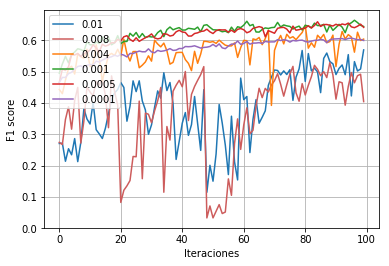

In [10]:
mob_01_f1 = pd.read_csv(main_path + 'f1_0.01.csv')
mob_008_f1 = pd.read_csv(main_path + 'f1_0.008.csv')
mob_004_f1 = pd.read_csv(main_path + 'f1_0.004.csv')
mob_001_f1 = pd.read_csv(main_path + 'f1_0.001.csv')
mob_0005_f1 = pd.read_csv(main_path + 'f1_0.0005.csv')
mob_0001_f1 = pd.read_csv(main_path + 'f1_0.0001.csv')

fig, ax = plt.subplots()
ax.plot(mob_01_f1['epoch'], mob_01_f1['f1 score'], label='0.01')
ax.plot(mob_008_f1['epoch'], mob_008_f1['f1 score'], color='indianred', label='0.008')
ax.plot(mob_004_f1['epoch'], mob_004_f1['f1 score'], label='0.004')
ax.plot(mob_001_f1['epoch'], mob_001_f1['f1 score'], label='0.001')
ax.plot(mob_0005_f1['epoch'], mob_0005_f1['f1 score'], label='0.0005')
ax.plot(mob_0001_f1['epoch'], mob_0001_f1['f1 score'], label='0.0001')

plt.grid(True)
plt.xlabel('Iteraciones')
plt.ylabel('F1 score')
plt.legend(loc='upper left')
plt.savefig('mejor_tasa.pdf')

## Remaining training parameters

In [9]:
# Define a learning rate schedule.
def lr_schedule(epoch):
    if epoch < 400:
        return 0.0005
    else:
        return 0.0001

In [10]:
scale_factors = [1.5]

for factor in scale_factors:
    # 1: Build the Keras model.
    K.clear_session() # Clear previous models from memory.

    print('TRAINING MODEL WITH FACTOR:', factor)
    
    model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                scale_factor=factor,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)

    adam = Adam(lr=0.001)
    ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
    model.load_weights('/home/aldo/Documents/weights/light_models/PASCAL/shufflenet_v2_ssdlayers_light_relu6_se_no_shuffle_factor_1.5.h5', by_name=True)
    model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
    
    # Define model callbacks.
    main_path = '/home/aldo/Documents/'
    # TODO: Set the filepath under which you want to save the model.

    csv_logger = CSVLogger(filename=main_path + 'data-cic/history/light_models/CIC/shufflenet_v2_ssdlayers_light_relu6_se_no_shuffle_factor_' + 
                           str(factor) + '.csv',
                           separator=',',
                           append=True)

    learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule, verbose=1)


    callbacks = [csv_logger,
                 learning_rate_scheduler]
    
    initial_epoch   = 0
    final_epoch     = 500
    steps_per_epoch = 15

    history = model.fit_generator(generator=train_generator,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=final_epoch,
                                  callbacks=callbacks,
                                  initial_epoch=initial_epoch)
    
    model.save(main_path + 'weights/light_models/CIC/shufflenet_v2_ssdlayers_light_relu6_se_no_shuffle_factor_' + str(factor) + '.h5')

TRAINING MODEL WITH FACTOR: 1.5
Epoch 1/500

Epoch 00001: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 21s 1s/step - loss: 3.8730
Epoch 2/500

Epoch 00002: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 11s 730ms/step - loss: 3.7024
Epoch 3/500

Epoch 00003: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 12s 779ms/step - loss: 3.5103
Epoch 4/500

Epoch 00004: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 12s 780ms/step - loss: 3.4414
Epoch 5/500

Epoch 00005: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 11s 727ms/step - loss: 3.4558
Epoch 6/500

Epoch 00006: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 12s 777ms/step - loss: 3.2199
Epoch 7/500

Epoch 00007: LearningRateScheduler setting lea

15/15 [==============================] - 11s 756ms/step - loss: 2.5056
Epoch 55/500

Epoch 00055: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 12s 776ms/step - loss: 2.6495
Epoch 56/500

Epoch 00056: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 11s 764ms/step - loss: 2.5712
Epoch 57/500

Epoch 00057: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 12s 767ms/step - loss: 2.6641
Epoch 58/500

Epoch 00058: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 12s 774ms/step - loss: 2.5717
Epoch 59/500

Epoch 00059: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 11s 754ms/step - loss: 2.4480
Epoch 60/500

Epoch 00060: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 11s 744ms/step - loss: 2.4766
Epoch 61/50

15/15 [==============================] - 12s 774ms/step - loss: 2.3039
Epoch 109/500

Epoch 00109: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 12s 774ms/step - loss: 2.3875
Epoch 110/500

Epoch 00110: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 12s 784ms/step - loss: 2.4090
Epoch 111/500

Epoch 00111: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 12s 790ms/step - loss: 2.3669
Epoch 112/500

Epoch 00112: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 12s 774ms/step - loss: 2.3614
Epoch 113/500

Epoch 00113: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 11s 762ms/step - loss: 2.3959
Epoch 114/500

Epoch 00114: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 12s 804ms/step - loss: 2.3373
Epoch

15/15 [==============================] - 12s 796ms/step - loss: 2.1890
Epoch 162/500

Epoch 00162: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 12s 796ms/step - loss: 2.1558
Epoch 163/500

Epoch 00163: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 11s 759ms/step - loss: 2.1747
Epoch 164/500

Epoch 00164: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 11s 751ms/step - loss: 2.1434
Epoch 165/500

Epoch 00165: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 11s 729ms/step - loss: 2.0584
Epoch 166/500

Epoch 00166: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 12s 774ms/step - loss: 2.1048
Epoch 167/500

Epoch 00167: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 12s 769ms/step - loss: 2.1744
Epoch

15/15 [==============================] - 12s 771ms/step - loss: 2.0996
Epoch 215/500

Epoch 00215: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 11s 758ms/step - loss: 1.9463
Epoch 216/500

Epoch 00216: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 11s 752ms/step - loss: 2.0493
Epoch 217/500

Epoch 00217: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 11s 717ms/step - loss: 1.9803
Epoch 218/500

Epoch 00218: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 12s 782ms/step - loss: 2.0912
Epoch 219/500

Epoch 00219: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 11s 738ms/step - loss: 1.9610
Epoch 220/500

Epoch 00220: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 12s 782ms/step - loss: 2.0523
Epoch

15/15 [==============================] - 11s 762ms/step - loss: 2.1123
Epoch 268/500

Epoch 00268: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 11s 737ms/step - loss: 1.9982
Epoch 269/500

Epoch 00269: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 11s 709ms/step - loss: 1.9230
Epoch 270/500

Epoch 00270: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 11s 715ms/step - loss: 1.8974
Epoch 271/500

Epoch 00271: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 11s 753ms/step - loss: 2.0681
Epoch 272/500

Epoch 00272: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 11s 726ms/step - loss: 2.0677
Epoch 273/500

Epoch 00273: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 11s 718ms/step - loss: 2.0033
Epoch

15/15 [==============================] - 11s 715ms/step - loss: 1.9281
Epoch 321/500

Epoch 00321: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 11s 716ms/step - loss: 1.9685
Epoch 322/500

Epoch 00322: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 11s 759ms/step - loss: 1.8921
Epoch 323/500

Epoch 00323: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 11s 727ms/step - loss: 1.9107
Epoch 324/500

Epoch 00324: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 11s 732ms/step - loss: 1.9277
Epoch 325/500

Epoch 00325: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 11s 746ms/step - loss: 1.8467
Epoch 326/500

Epoch 00326: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 11s 742ms/step - loss: 1.8618
Epoch

15/15 [==============================] - 11s 704ms/step - loss: 1.7537
Epoch 374/500

Epoch 00374: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 11s 750ms/step - loss: 1.7735
Epoch 375/500

Epoch 00375: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 11s 741ms/step - loss: 1.7722
Epoch 376/500

Epoch 00376: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 11s 717ms/step - loss: 1.7163
Epoch 377/500

Epoch 00377: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 11s 715ms/step - loss: 1.8731
Epoch 378/500

Epoch 00378: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 11s 740ms/step - loss: 1.8701
Epoch 379/500

Epoch 00379: LearningRateScheduler setting learning rate to 0.0005.
15/15 [==============================] - 11s 730ms/step - loss: 1.8148
Epoch

15/15 [==============================] - 11s 761ms/step - loss: 1.7249
Epoch 427/500

Epoch 00427: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 11s 722ms/step - loss: 1.6533
Epoch 428/500

Epoch 00428: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 11s 724ms/step - loss: 1.6905
Epoch 429/500

Epoch 00429: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 11s 753ms/step - loss: 1.7378
Epoch 430/500

Epoch 00430: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 12s 770ms/step - loss: 1.8715
Epoch 431/500

Epoch 00431: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 11s 763ms/step - loss: 1.8075
Epoch 432/500

Epoch 00432: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 11s 739ms/step - loss: 1.8550
Epoch

15/15 [==============================] - 11s 712ms/step - loss: 1.6885
Epoch 480/500

Epoch 00480: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 11s 744ms/step - loss: 1.7674
Epoch 481/500

Epoch 00481: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 11s 725ms/step - loss: 1.7269
Epoch 482/500

Epoch 00482: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 11s 748ms/step - loss: 1.7902
Epoch 483/500

Epoch 00483: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 11s 716ms/step - loss: 1.7274
Epoch 484/500

Epoch 00484: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 11s 730ms/step - loss: 1.6910
Epoch 485/500

Epoch 00485: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 11s 723ms/step - loss: 1.7040
Epoch